# 프로모션 효율 예측 (Random Forest)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mem = pd.read_csv('member.csv')
tran = pd.read_csv('transaction.csv')

In [4]:
mem.head()

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0


- id 랜덤 숫자 부여
- recency 몇일전 부여 ( 10일전 , 6일전 ...)
- zip_code 우편번호 가공됨 
- is_referral 추천인으로 가입했는지 미가입했는지 부여
- conversion => promotion 받고나서 구매로 전환되었는지 /예측하고자 하는 컬럼


In [5]:
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [6]:
mem.describe()

,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


In [7]:
tran.head()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


- num_item => 몇개의 물품 구매했는지 
- total_amount => 총 금액 얼마인지

In [8]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [9]:
tran.describe()

,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


In [12]:
tran['avg_price'] = tran['total_amount'] / tran['num_item']

In [13]:
tran

,id,num_item,total_amount,avg_price
0,906145,5,34000,6800.000000
1,906145,1,27000,27000.000000
2,906145,4,33000,8250.000000
3,184478,4,29000,7250.000000
4,394235,4,33000,8250.000000
...,...,...,...,...
196831,536246,5,24000,4800.000000
196832,927617,5,26000,5200.000000
196833,927617,3,22000,7333.333333
196834,927617,3,18000,6000.000000


In [18]:
tran_mean = tran.groupby('id').mean()

In [20]:
tran_cnt = tran['id'].value_counts()

In [21]:
tran_mean

,num_item,total_amount,avg_price
id,,,
100001,3.500000,26000.000000,7500.000000
100008,5.000000,26000.000000,5200.000000
100032,2.666667,20666.666667,9366.666667
100036,3.000000,25800.000000,13273.333333
100070,3.250000,21250.000000,8537.500000
...,...,...,...
999932,5.000000,32000.000000,6400.000000
999981,2.000000,22750.000000,12875.000000
999990,3.000000,28000.000000,10388.888889


In [22]:
tran_cnt

940317    5
754878    5
808126    5
876005    5
538399    5
         ..
781792    1
579795    1
806627    1
803008    1
586290    1
Name: id, Length: 64000, dtype: int64

In [24]:
tran_df = pd.concat([tran_mean, tran_cnt], axis=1)

In [28]:
# 칼럼 명 변경하기 1
tran_df.columns = ['num_item', 'total_amount', 'avg_price', 'count']

In [29]:
# 칼럼 명 변경하기 2
tran_df.rename(columns={'id': 'count'}) #id칼럼명을 count 이름으로변경

,num_item,total_amount,avg_price,count
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


In [30]:
tran_df

,num_item,total_amount,avg_price,count
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


In [32]:
mem.set_index('id', inplace=True) #tran_df 와 합쳐주기 위해 index를 id로 변경하기

In [33]:
mem

,recency,zip_code,is_referral,channel,conversion
id,,,,,
906145,10,Surburban,0,Phone,0
184478,6,Rural,1,Web,0
394235,7,Surburban,1,Web,0
130152,9,Rural,1,Web,0
940352,2,Urban,0,Web,0
...,...,...,...,...,...
838295,10,Urban,0,Web,0
547316,5,Urban,1,Phone,0
131575,6,Urban,1,Phone,0


In [34]:
mem.join(tran_df)

,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price,count
id,,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667,3
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000,1
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000,2
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000,4
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333,1
...,...,...,...,...,...,...,...,...,...
838295,10,Urban,0,Web,0,3.500000,26000.000000,8012.500000,4
547316,5,Urban,1,Phone,0,1.800000,17800.000000,11300.000000,5
131575,6,Urban,1,Phone,0,4.000000,30500.000000,7833.333333,2


In [35]:
data = mem.join(tran_df)

In [36]:
data

,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price,count
id,,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667,3
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000,1
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000,2
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000,4
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333,1
...,...,...,...,...,...,...,...,...,...
838295,10,Urban,0,Web,0,3.500000,26000.000000,8012.500000,4
547316,5,Urban,1,Phone,0,1.800000,17800.000000,11300.000000,5
131575,6,Urban,1,Phone,0,4.000000,30500.000000,7833.333333,2


In [38]:
data.isna().sum() / len(data)
#missing value 값 확인하기

recency         0.0
zip_code        0.0
is_referral     0.0
channel         0.0
conversion      0.0
num_item        0.0
total_amount    0.0
avg_price       0.0
count           0.0
dtype: float64

In [39]:
data['zip_code'].nunique()

3

In [40]:
data['zip_code'].unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [41]:
data['channel'].nunique()

3

In [42]:
data['channel'].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

In [46]:
pd.get_dummies(data, columns=['zip_code', 'channel'])

,recency,is_referral,conversion,num_item,total_amount,avg_price,count,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
id,,,,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,3,0,1,0,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,1,1,0,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,2,0,1,0,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,4,1,0,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,4,0,0,1,0,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,5,0,0,1,0,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,2,0,0,1,0,1,0


- zip_code_Rural,	zip_code_Surburban,	zip_code_Urban,	channel_Multichannel,	channel_Phone,	channel_Web
 데이터 프레임에 나타나짐

In [48]:
data = pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first=True)

- zip_code_Surburban,	zip_code_Urban,	channel_Phone,	channel_Web
  drop_first=True 으로 칼럼 3개를 2개만 나타나게끔 함

In [49]:
data

,recency,is_referral,conversion,num_item,total_amount,avg_price,count,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
id,,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,3,1,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,1,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,2,1,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,4,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,4,0,1,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,5,0,1,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,2,0,1,1,0


# 랜덤 포레스트 모델 만들기

- 랜덤 포레스트는 여러 개의 결정트리(Decision Tree)를 활용한 배깅 방식의 대표적인 알고리즘
- 장점 => 
          결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있음
          앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있음
          다양한 분야에서 좋은 성능을 나타냄
- 단점 => 하이퍼 파라미터가 많아 튜닝을 위힌 시간이 많이 소요됨

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
X_train,X_test,y_train,y_test = train_test_split(data.drop('conversion', axis=1),data['conversion'],test_size=0.3, random_state=100)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
model = RandomForestClassifier(max_depth=10,random_state=100)

In [56]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, random_state=100)

In [58]:
pred = model.predict(X_test)

In [59]:
y_test

id
632233    0
412308    0
184792    0
546903    0
113517    0
         ..
629047    0
470260    0
673575    0
345057    0
182726    0
Name: conversion, Length: 19200, dtype: int64

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [61]:
accuracy_score(y_test,pred)

0.87515625

In [62]:
confusion_matrix(y_test, pred)

array([[16403,    60],
       [ 2337,   400]], dtype=int64)

In [63]:
from sklearn.metrics import classification_report

- 사이킷런 패키지의 metrics 패키지에서는 정밀도, 재현율, F1점수를 구하는 classification_report 명령을 제공한다. 이 명령은 각각의 클래스를 양성(positive) 클래스로 보았을 때의 정밀도, 재현율, F1점수를 각각 구하고 그 평균값으로 전체 모형의 성능을 평가한다.

In [65]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     16463
           1       0.87      0.15      0.25      2737

    accuracy                           0.88     19200
   macro avg       0.87      0.57      0.59     19200
weighted avg       0.87      0.88      0.83     19200



In [66]:
from sklearn.ensemble import RandomForestRegressor

- 랜덤 포레스트는 데이터셋의 다양한 하위 샘플을 이용해서 다 수의 "분류 의사 결정 트리(classifying  decision tree)"를 학습하는 메타 예측기(a meta estimator)다. 과적합을 조절하고 예측의 정확도를 높이기 위해서 평균을 사용한다.


- 가장 정확한 학습 알고리즘 중 하나다. 많은 데이터셋에 대해서 매우 정확한 분류자(classifier)를 만든다.
- 대량의 데이터베이스에서 효과적으로 작동한다.
- 수천 개의 입력 변수를 처리할 수 있다.
- 분류할 때 중요한 변수가 무엇인지 예측할 수 있다.
- 포레스트(숲)을 만들면서 일반화 오류의 편향되지 않은 내부 예측치를 생성한다.
- 결측치를 예측하는 효과적인 방법을 제공해서 높은 비율의 데이터가 결여되도 정확도를 유지한다.

In [67]:
rf = RandomForestRegressor(max_depth=10, random_state=100)

In [68]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, random_state=100)

In [71]:
pred = rf.predict(X_test)

In [72]:
pd.DataFrame(pred)

,0
0,0.000000
1,0.058584
2,0.000000
3,0.594169
4,0.083316
...,...
19195,0.142431
19196,0.000000
19197,0.116323
19198,0.000000


In [73]:
y_test

id
632233    0
412308    0
184792    0
546903    0
113517    0
         ..
629047    0
470260    0
673575    0
345057    0
182726    0
Name: conversion, Length: 19200, dtype: int64

In [74]:
def conv(x):
    if x >=0.5:
        return 1
    else:
        return 0

In [79]:
# 첫번째 방법 
pd_result = pd.Series(pred).apply(lambda x: conv(x)) #pred 을 0,1으로만 구분하기

In [80]:
pd_result

0        0
1        0
2        0
3        1
4        0
        ..
19195    0
19196    0
19197    0
19198    0
19199    0
Length: 19200, dtype: int64

In [77]:
# 두번째 방법
result = []
for i in pred:
    result.append(conv(i))

In [78]:
result

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [82]:
# 세번째 방법
result_comp = [1 if x >= 0.5 else 0 for x in pred]

In [83]:
accuracy_score(y_test, result_comp)

0.8799479166666667

In [84]:
confusion_matrix(y_test, result_comp)

array([[16313,   150],
       [ 2155,   582]], dtype=int64)

In [85]:
print(classification_report(y_test, result_comp))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     16463
           1       0.80      0.21      0.34      2737

    accuracy                           0.88     19200
   macro avg       0.84      0.60      0.63     19200
weighted avg       0.87      0.88      0.85     19200



In [86]:
result_3 = [1 if x >= 0.3 else 0 for x in pred]

In [87]:
print(classification_report(y_test, result_3))

              precision    recall  f1-score   support

           0       0.90      0.96      0.92     16463
           1       0.55      0.33      0.42      2737

    accuracy                           0.87     19200
   macro avg       0.72      0.64      0.67     19200
weighted avg       0.85      0.87      0.85     19200



- precision, recall, f1-score 보고 상황에 맞는   classification_report 선택!

In [88]:
rf = RandomForestRegressor(max_depth=10 ,random_state=100)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >=0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8799479166666667

In [89]:
rf = RandomForestRegressor(max_depth=12 ,random_state=100)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >=0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8805729166666667

In [93]:
rf = RandomForestRegressor(n_estimators=100, max_depth=12 ,random_state=100, min_samples_leaf=5)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >=0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8810416666666666

- n_estimators 트리 갯수 /n_estimators : 생성할 tree의 개수
    

In [94]:
rf.feature_importances_ #각각의 변수가 얼마나 중요한지 나타내줌

array([0.06390282, 0.0229547 , 0.31878145, 0.15857333, 0.25092914,
       0.14468844, 0.00936383, 0.00914032, 0.01179997, 0.009866  ])

In [95]:
X_train.columns

Index(['recency', 'is_referral', 'num_item', 'total_amount', 'avg_price',
       'count', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone',
       'channel_Web'],
      dtype='object')

<AxesSubplot:>

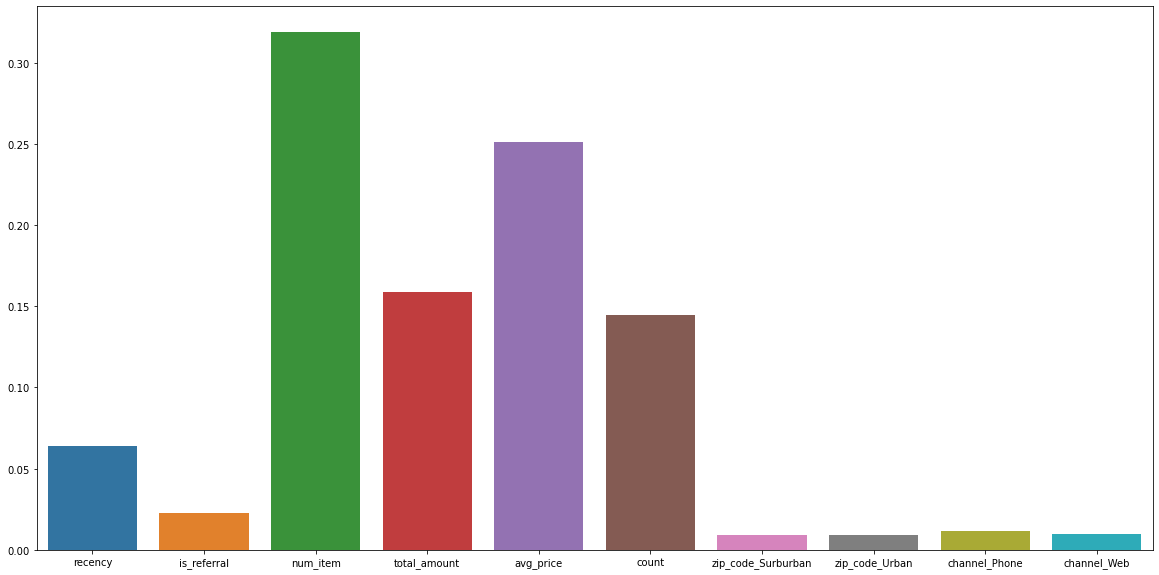

In [97]:
plt.figure(figsize=(20,10))
sns.barplot(x = X_train.columns, y = rf.feature_importances_)